In [1]:
import pandas as pd
import numpy as np
import re
import requests
from pathlib import Path
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')


## 1. Configure Paths

In [2]:

BASE_DIR = Path("/home/aditya/synapse_motif_analysis/outputs/excitatory")
ATTRIBUTION_FILE = Path("/home/aditya/synapse_motif_analysis/excitatory_attributions_precise.csv")


OUTPUT_DIR = BASE_DIR / "analysis_results"
OUTPUT_DIR.mkdir(exist_ok=True)

print(f"Base directory: {BASE_DIR}")
print(f"Attribution file: {ATTRIBUTION_FILE}")
print(f"Output directory: {OUTPUT_DIR}")

Base directory: /home/aditya/synapse_motif_analysis/outputs/excitatory
Attribution file: /home/aditya/synapse_motif_analysis/excitatory_attributions_precise.csv
Output directory: /home/aditya/synapse_motif_analysis/outputs/excitatory/analysis_results


## 2. Load Attribution Data

In [9]:

df_attr = pd.read_csv(ATTRIBUTION_FILE)


df_attr = df_attr[df_attr['name'].astype(str).str.match(r'^[A-Z]\w+')]
df_attr['uniprot_clean'] = df_attr['name'].str.extract(r'^([A-Z0-9]+)(?:_.*)?$')[0]

print("\nExamples of UniProt ID cleaning:")
sample_names = df_attr[['name', 'uniprot_clean']].drop_duplicates().head(10)
for idx, row in sample_names.iterrows():
    if row['name'] != row['uniprot_clean']:
        print(f"  {row['name']} -> {row['uniprot_clean']}")

print(f"\nLoaded {len(df_attr)} valid protein sequences")
print(f"Unique proteins (after cleaning IDs): {df_attr['uniprot_clean'].nunique()}")
print(f"\nColumns: {df_attr.columns.tolist()}")
print(f"\nFirst few rows:")
df_attr.head()


Examples of UniProt ID cleaning:

Loaded 419 valid protein sequences
Unique proteins (after cleaning IDs): 413

Columns: ['condensate', 'name', 'seed', 'sequence', 'model_pred_class_idx', 'model_pred_class_name', 'model_pred_probs', 'attributions', 'full_sequence', 'uniprot_clean']

First few rows:


,condensate,name,seed,sequence,model_pred_class_idx,model_pred_class_name,model_pred_probs,attributions,full_sequence,uniprot_clean
0,Excitatory Synapse,A6NGB9,1,MPVPPPPPPPLPPPPPPLGAPPPPPPSAPPVSTDTSSLRRADPKGR...,4,Excitatory Synapse,"[0.44193926453590393, 0.003099618712440133, 0....","[0.04422703034284124, 0.009124322262893949, -0...",MPVPPPPPPPLPPPPPPLGAPPPPPPSAPPVSTDTSSLRRADPKGR...,A6NGB9
1,Excitatory Synapse,A6NL88,1,MPALLLLVLLASSAGQARARPSNATSAEPAGPLPALLAHLRRLTGA...,1,ER,"[0.023124029859900475, 0.4174041450023651, 0.1...","[-0.025818322004189535, 0.13300886455962355, 0...",MPALLLLVLLASSAGQARARPSNATSAEPAGPLPALLAHLRRLTGA...,A6NL88
2,Excitatory Synapse,A7KAX9,1,METESESSTLGDDSVFWLESEVIIQVTDCEEEEREEKFRKMKSSVH...,0,cytosol,"[0.5994824171066284, 0.00457895128056407, 0.00...","[-0.015187134977179126, 0.026925277368677145, ...",METESESSTLGDDSVFWLESEVIIQVTDCEEEEREEKFRKMKSSVH...,A7KAX9
3,Excitatory Synapse,A8MVW0,1,MPPASGPSVLARLLPLLGLLLGSASRAPGKSPPEPPSPQEILIKVQ...,4,Excitatory Synapse,"[0.03715946897864342, 0.07373550534248352, 0.0...","[0.029751342067075134, -0.005858824388094078, ...",MPPASGPSVLARLLPLLGLLLGSASRAPGKSPPEPPSPQEILIKVQ...,A8MVW0
4,Excitatory Synapse,O00305,1,MSSSSYAKNGTADGPHSPTSQVARGTTTRRSRLKRSDGSTTSTSFI...,3,nucleus,"[0.17241087555885315, 0.0008862375980243087, 1...","[0.006304305926024734, -0.07420662500931198, -...",MSSSSYAKNGTADGPHSPTSQVARGTTTRRSRLKRSDGSTTSTSFI...,O00305


## 3. Function to Get Protein Names from UniProt

In [10]:
def get_protein_info_from_uniprot(uniprot_id, cache={}):
    """
    Fetch comprehensive protein information from UniProt API with caching
    
    Returns:
        dict: {
            'gene_name': str,
            'protein_name': str,
            'status': str,
            'organism': str,
            'amino_acids': int,
            'protein_existence': str,
            'annotation_score': str,
            'function': str
        }
    """
    if uniprot_id in cache:
        return cache[uniprot_id]
    
    info = {
        'gene_name': None,
        'protein_name': None,
        'status': None,
        'organism': None,
        'amino_acids': None,
        'protein_existence': None,
        'annotation_score': None,
        'function': None
    }
    
    gene_symbol = None
    function_lines = []
    collecting_function = False
    
    try:
        url = f"https://rest.uniprot.org/uniprotkb/{uniprot_id}.txt"
        response = requests.get(url, timeout=5)
        
        if response.status_code == 200:
            lines = response.text.split('\n')
            
            for i, line in enumerate(lines):
                if line.startswith('ID   '):
                    if 'Reviewed' in line:
                        info['status'] = 'Reviewed'
                    elif 'Unreviewed' in line:
                        info['status'] = 'Unreviewed'
                    parts = line.split(';')
                    if len(parts) >= 2:
                        aa_part = parts[-1].strip()
                        aa_match = re.search(r'(\d+)\s+AA', aa_part)
                        if aa_match:
                            info['amino_acids'] = int(aa_match.group(1))

                if info['protein_name'] is None:
                    if line.startswith('DE   RecName: Full='):
                        info['protein_name'] = line.replace('DE   RecName: Full=', '').strip().rstrip(';')
                    elif line.startswith('DE   SubName: Full='):
                        info['protein_name'] = line.replace('DE   SubName: Full=', '').strip().rstrip(';')

                if line.startswith('GN   Name='):
                    parts = line.replace('GN   Name=', '').split(';')
                    if parts:
                        gene_symbol = parts[0].strip()

                if line.startswith('OS   '):
                    organism = line.replace('OS   ', '').strip().rstrip('.')
                    info['organism'] = organism
                    

                    if gene_symbol:
                        if 'Homo sapiens' in organism:
                            info['gene_name'] = f"{gene_symbol}_HUMAN"
                        elif 'Mus musculus' in organism:
                            info['gene_name'] = f"{gene_symbol}_MOUSE"
                        elif 'Rattus norvegicus' in organism:
                            info['gene_name'] = f"{gene_symbol}_RAT"
                        else:
                            info['gene_name'] = gene_symbol
                
                if line.startswith('PE   '):
                    pe_text = line.replace('PE   ', '').strip().rstrip(';')
                    info['protein_existence'] = pe_text
                

                if info['status'] == 'Reviewed':
                    info['annotation_score'] = '5 out of 5'
                elif info['status'] == 'Unreviewed':
                    info['annotation_score'] = 'Not scored'
                
                if line.startswith('CC   -!- FUNCTION:'):
                    function_text = line.replace('CC   -!- FUNCTION:', '').strip()
                    function_lines.append(function_text)
                    collecting_function = True
                elif collecting_function and line.startswith('CC       '):

                    function_text = line.replace('CC       ', '').strip()
                    function_lines.append(function_text)
                elif collecting_function and (line.startswith('CC   -!-') or not line.startswith('CC')):

                    collecting_function = False
            

            if function_lines:
                info['function'] = ' '.join(function_lines)
    
    except Exception as e:
        print(f"Error fetching {uniprot_id}: {e}")
    

    if info['gene_name'] is None:
        info['gene_name'] = uniprot_id
    if info['protein_name'] is None:
        info['protein_name'] = uniprot_id
    if info['status'] is None:
        info['status'] = 'Unknown'
    if info['organism'] is None:
        info['organism'] = 'Unknown'
    if info['amino_acids'] is None:
        info['amino_acids'] = 0
    if info['protein_existence'] is None:
        info['protein_existence'] = 'Unknown'
    if info['annotation_score'] is None:
        info['annotation_score'] = 'Unknown'
    if info['function'] is None:
        info['function'] = 'No function information available'
    
    cache[uniprot_id] = info
    return info

print("Function defined. Testing with sample ID...")
test_info = get_protein_info_from_uniprot("A6NGB9")
print(f"Test result:")
for key, value in test_info.items():
    if key == 'function':
        print(f"  {key}: {value[:100]}..." if len(str(value)) > 100 else f"  {key}: {value}")
    else:
        print(f"  {key}: {value}")

Function defined. Testing with sample ID...
Test result:
  gene_name: WIPF3_HUMAN
  protein_name: WAS/WASL-interacting protein family member 3
  status: Reviewed
  organism: Homo sapiens (Human)
  amino_acids: 483
  protein_existence: 1: Evidence at protein level
  annotation_score: 5 out of 5
  function: May be a regulator of cytoskeletal organization. May have a role in spermatogenesis (By similarity)....


## 4. Convert IUPAC Motif Notation to Regex

In [11]:
def iupac_to_regex(motif_consensus):

    iupac_map = {
        'B': '[DN]',  
        'Z': '[EQ]', 
        'J': '[IL]',   
        'X': '[ACDEFGHIKLMNPQRSTVWY]',  
    }
    
    pattern = ''
    for char in motif_consensus:
        if char in iupac_map:
            pattern += iupac_map[char]
        else:
            pattern += char  
    
    return pattern


print("Testing IUPAC to regex conversion:")
test_motifs = [
    'HHHHH',  
    'HBHHH',  
    'HZHHH',   
    'HJHHH',   
    'HXHHH', 
    'BXZJH'    
]
for motif in test_motifs:
    regex = iupac_to_regex(motif)
    print(f"{motif:10s} -> {regex}")

Testing IUPAC to regex conversion:
HHHHH      -> HHHHH
HBHHH      -> H[DN]HHH
HZHHH      -> H[EQ]HHH
HJHHH      -> H[IL]HHH
HXHHH      -> H[ACDEFGHIKLMNPQRSTVWY]HHH
BXZJH      -> [DN][ACDEFGHIKLMNPQRSTVWY][EQ][IL]H


## 5. Find Motif Files and Process Them

In [12]:

motif_files = sorted(BASE_DIR.glob("*.csv"))

print(f"Found {len(motif_files)} CSV files:")
for f in motif_files:
    print(f"  - {f.name}")

valid_motif_files = []
print(f"\nChecking file formats...")
for f in motif_files:
    try:

        df_check = pd.read_csv(f, sep=',', nrows=1)
        df_check.columns = df_check.columns.str.strip()
        
        if 'CONSENSUS' in df_check.columns:
            valid_motif_files.append(f)
            print(f"  ✓ {f.name} - Valid motif file")
        else:
            print(f"  ✗ {f.name} - Missing CONSENSUS column")
            print(f"     Columns found: {df_check.columns.tolist()}")
    except Exception as e:
        print(f"  ✗ {f.name} - Error reading file: {e}")

motif_files = valid_motif_files
print(f"\nUsing {len(motif_files)} valid motif files for analysis.")

if len(motif_files) == 0:
    print("\n⚠️ WARNING: No valid motif files found!")
    print("Please check the file format and delimiter.")

def parse_filename(filename):
    """
    Extract window and padding from filename like 'Excitatory - Rank analysis - w5 p0.csv'
    """
    match = re.search(r'w(\d+)\s*p(\d+)', filename)
    if match:
        return f"w{match.group(1)}_p{match.group(2)}"
    return "unknown"

print(f"\nFilename parsing:")
for f in motif_files:
    wp = parse_filename(f.name)
    print(f"  {f.name} -> {wp}")

Found 6 CSV files:
  - Excitatory - Rank analysis - w11 p2.csv
  - Excitatory - Rank analysis - w15 p3.csv
  - Excitatory - Rank analysis - w5 p0.csv
  - Excitatory - Rank analysis - w7 p2.csv
  - Excitatory - Rank analysis - w9 p3.csv
  - Excitatory - Rank analysis - w9 p5.csv

Checking file formats...
  ✓ Excitatory - Rank analysis - w11 p2.csv - Valid motif file
  ✓ Excitatory - Rank analysis - w15 p3.csv - Valid motif file
  ✓ Excitatory - Rank analysis - w5 p0.csv - Valid motif file
  ✓ Excitatory - Rank analysis - w7 p2.csv - Valid motif file
  ✓ Excitatory - Rank analysis - w9 p3.csv - Valid motif file
  ✓ Excitatory - Rank analysis - w9 p5.csv - Valid motif file

Using 6 valid motif files for analysis.

Filename parsing:
  Excitatory - Rank analysis - w11 p2.csv -> w11_p2
  Excitatory - Rank analysis - w15 p3.csv -> w15_p3
  Excitatory - Rank analysis - w5 p0.csv -> w5_p0
  Excitatory - Rank analysis - w7 p2.csv -> w7_p2
  Excitatory - Rank analysis - w9 p3.csv -> w9_p3
  Excit

## 5.5 Check for Ambiguous Symbols in Motif Files

In [13]:

ambiguous_symbols = set('BZJX')
motifs_with_ambiguous = []

print("Checking for ambiguous symbols (B, Z, J, X) in motif consensus patterns...\n")

if len(motif_files) == 0:
    print("⚠️ No valid motif files to check.")
else:
    for motif_file in motif_files:
        df_temp = pd.read_csv(motif_file, sep=',')
        df_temp.columns = df_temp.columns.str.strip()
        for idx, row in df_temp.iterrows():
            consensus = str(row['CONSENSUS'])
            found_symbols = set(consensus) & ambiguous_symbols
            if found_symbols:
                motifs_with_ambiguous.append({
                    'file': motif_file.name,
                    'consensus': consensus,
                    'ambiguous_symbols': ','.join(sorted(found_symbols))
                })
    
    if motifs_with_ambiguous:
        print(f"Found {len(motifs_with_ambiguous)} motifs with ambiguous symbols:\n")
        for m in motifs_with_ambiguous[:10]:  # Show first 10
            print(f"  {m['file']}: {m['consensus']} (contains {m['ambiguous_symbols']})")
        if len(motifs_with_ambiguous) > 10:
            print(f"  ... and {len(motifs_with_ambiguous) - 10} more")
        print(f"\n✓ The iupac_to_regex() function will properly handle these!")
    else:
        print("No ambiguous symbols found in any motif consensus patterns.")
        print("All motifs use only standard amino acids (A-Y).")
        print("The iupac_to_regex() function is still included for robustness.")

Checking for ambiguous symbols (B, Z, J, X) in motif consensus patterns...

Found 52 motifs with ambiguous symbols:

  Excitatory - Rank analysis - w11 p2.csv: LWRXY (contains X)
  Excitatory - Rank analysis - w11 p2.csv: SXXDA (contains X)
  Excitatory - Rank analysis - w11 p2.csv: XGKK (contains X)
  Excitatory - Rank analysis - w11 p2.csv: LXDFP (contains X)
  Excitatory - Rank analysis - w11 p2.csv: LXKFLLK (contains X)
  Excitatory - Rank analysis - w11 p2.csv: RXRXXSXXX (contains X)
  Excitatory - Rank analysis - w11 p2.csv: HXKXXSX (contains X)
  Excitatory - Rank analysis - w11 p2.csv: WXXXJXAA (contains J,X)
  Excitatory - Rank analysis - w15 p3.csv: LAXXJXXXL (contains J,X)
  Excitatory - Rank analysis - w15 p3.csv: IICCVILGIVJA (contains J)
  ... and 42 more

✓ The iupac_to_regex() function will properly handle these!


## 6. Main Analysis Function

In [14]:
def find_proteins_with_motif(motif_consensus, sequences_df):
    """
    Find all proteins that contain the given motif
    
    Returns:
        List of tuples: (uniprot_id_clean, s_no)
    """
    pattern = iupac_to_regex(motif_consensus)
    regex = re.compile(pattern)
    
    matching_proteins = []
    
    for idx, row in sequences_df.iterrows():
        sequence = str(row['sequence'])
        uniprot_id_clean = row['uniprot_clean']  # Use cleaned ID
        
        if regex.search(sequence):
            matching_proteins.append((uniprot_id_clean, idx))
    
    return matching_proteins

print("Analysis function defined successfully!")

Analysis function defined successfully!


## 7. Process All Motif Files

In [15]:

all_motif_results = []
protein_motif_map = defaultdict(list)  # uniprot_id -> [(consensus, window_padding), ...]

print("Processing motif files...\n")

for motif_file in motif_files:
    window_padding = parse_filename(motif_file.name)
    print(f"Processing: {motif_file.name} ({window_padding})")

    df_motif = pd.read_csv(motif_file, sep=',')
    df_motif.columns = df_motif.columns.str.strip()

    for idx, motif_row in df_motif.iterrows():
        rank = motif_row['RANK']
        consensus = motif_row['CONSENSUS']
        width = motif_row['WIDTH']
        sites = motif_row['SITES']
        sea_pvalue = motif_row['SEA_PVALUE']
        evalue = motif_row['EVALUE']
        motif_url = motif_row['MOTIF_URL'] if pd.notna(motif_row['MOTIF_URL']) else ''

        matching_proteins = find_proteins_with_motif(consensus, df_attr)

        if len(matching_proteins) > 0:
            uniprot_ids = [p[0] for p in matching_proteins]
            s_nos = [p[1] for p in matching_proteins]

            for uniprot_id in uniprot_ids:
                protein_motif_map[uniprot_id].append(f"{consensus}_{window_padding}")
            
            result_row = {
                'WINDOW_PADDING': window_padding,
                'RANK': rank,
                'CONSENSUS': consensus,
                'WIDTH': width,
                'SITES': sites,
                'SEA_PVALUE': sea_pvalue,
                'EVALUE': evalue,
                'MOTIF_URL': motif_url,
                'NUMBER_OF_PROTEINS_CONTAINING_THIS_MOTIF': len(matching_proteins),
                'UNIPROT_IDS': ','.join(uniprot_ids),

                'S_NOS_IN_ORIGINAL_FILE': ', '.join(str(s) for s in s_nos) 
            }
        else:

            result_row = {
                'WINDOW_PADDING': window_padding,
                'RANK': rank,
                'CONSENSUS': consensus,
                'WIDTH': width,
                'SITES': sites,
                'SEA_PVALUE': sea_pvalue,
                'EVALUE': evalue,
                'MOTIF_URL': motif_url,
                'NUMBER_OF_PROTEINS_CONTAINING_THIS_MOTIF': 0,
                'UNIPROT_IDS': '',
                'S_NOS_IN_ORIGINAL_FILE': ''
            }
        
        all_motif_results.append(result_row)
    
    print(f"  Found {len(df_motif)} motifs\n")

print(f"\nTotal motifs: {len(all_motif_results)}")
print(f"Motifs with protein matches: {sum(1 for r in all_motif_results if r['NUMBER_OF_PROTEINS_CONTAINING_THIS_MOTIF'] > 0)}")
print(f"Motifs with no matches: {sum(1 for r in all_motif_results if r['NUMBER_OF_PROTEINS_CONTAINING_THIS_MOTIF'] == 0)}")
print(f"Total unique proteins with motifs: {len(protein_motif_map)}")

Processing motif files...

Processing: Excitatory - Rank analysis - w11 p2.csv (w11_p2)
  Found 31 motifs

Processing: Excitatory - Rank analysis - w15 p3.csv (w15_p3)
  Found 39 motifs

Processing: Excitatory - Rank analysis - w5 p0.csv (w5_p0)
  Found 20 motifs

Processing: Excitatory - Rank analysis - w7 p2.csv (w7_p2)
  Found 25 motifs

Processing: Excitatory - Rank analysis - w9 p3.csv (w9_p3)
  Found 27 motifs

Processing: Excitatory - Rank analysis - w9 p5.csv (w9_p5)
  Found 32 motifs


Total motifs: 174
Motifs with protein matches: 143
Motifs with no matches: 31
Total unique proteins with motifs: 388


## 8. Fetch Protein Names from UniProt

In [16]:
print("Fetching comprehensive protein information from UniProt...\n")
print("This may take a few minutes depending on the number of unique proteins.\n")

all_uniprot_ids = set()
for result in all_motif_results:
    ids = result['UNIPROT_IDS'].split(',')
    all_uniprot_ids.update(ids)

print(f"Fetching info for {len(all_uniprot_ids)} unique proteins...")

info_cache = {}
for i, uniprot_id in enumerate(sorted(all_uniprot_ids), 1):
    if i % 10 == 0:
        print(f"  Progress: {i}/{len(all_uniprot_ids)}")
    info_cache[uniprot_id] = get_protein_info_from_uniprot(uniprot_id, info_cache)

print("\nProtein information fetched successfully!")
print(f"\nSample mappings:")
for i, (uid, info) in enumerate(list(info_cache.items())[:3]):
    print(f"\n{uid}:")
    print(f"  Gene: {info['gene_name']}")
    print(f"  Protein: {info['protein_name']}")
    print(f"  Status: {info['status']}")
    print(f"  Organism: {info['organism']}")
    print(f"  Amino acids: {info['amino_acids']}")

Fetching comprehensive protein information from UniProt...

This may take a few minutes depending on the number of unique proteins.

Fetching info for 389 unique proteins...
  Progress: 10/389
  Progress: 20/389
  Progress: 30/389
  Progress: 40/389
  Progress: 50/389
  Progress: 60/389
  Progress: 70/389
  Progress: 80/389
  Progress: 90/389
  Progress: 100/389
  Progress: 110/389
  Progress: 120/389
  Progress: 130/389
  Progress: 140/389
  Progress: 150/389
  Progress: 160/389
  Progress: 170/389
  Progress: 180/389
  Progress: 190/389
  Progress: 200/389
  Progress: 210/389
  Progress: 220/389
  Progress: 230/389
  Progress: 240/389
  Progress: 250/389
  Progress: 260/389
  Progress: 270/389
  Progress: 280/389
  Progress: 290/389
  Progress: 300/389
  Progress: 310/389
  Progress: 320/389
  Progress: 330/389
  Progress: 340/389
  Progress: 350/389
  Progress: 360/389
  Progress: 370/389
  Progress: 380/389

Protein information fetched successfully!

Sample mappings:

:
  Gene: 
  

## 9. Create Output 1: Motif Summary with Protein Names

In [17]:

for result in all_motif_results:
    if result['UNIPROT_IDS']: 
        uniprot_ids = result['UNIPROT_IDS'].split(',')
        default_info = {'gene_name': 'Unknown', 'protein_name': 'Unknown'}
        gene_names = [info_cache.get(uid, default_info)['gene_name'] for uid in uniprot_ids]
        protein_names = [info_cache.get(uid, default_info)['protein_name'] for uid in uniprot_ids]
        result['GENE_NAMES'] = '; '.join(gene_names)
        result['PROTEIN_NAMES'] = '; '.join(protein_names)
    else:
        result['GENE_NAMES'] = ''
        result['PROTEIN_NAMES'] = ''


df_motif_summary = pd.DataFrame(all_motif_results)

print(f"\nDataFrame columns: {df_motif_summary.columns.tolist()}")
print(f"DataFrame shape: {df_motif_summary.shape}")


if 'S_NOS_IN_ORIGINAL_FILE' in df_motif_summary.columns:
    df_motif_summary['S_NOS_IN_ORIGINAL_FILE'] = df_motif_summary['S_NOS_IN_ORIGINAL_FILE'].astype(str)
else:
    print("⚠️ Warning: S_NOS_IN_ORIGINAL_FILE column not found in results!")
    print(f"Available columns: {df_motif_summary.columns.tolist()}")


column_order = [
    'WINDOW_PADDING',
    'RANK',
    'CONSENSUS',
    'WIDTH',
    'SITES',
    'SEA_PVALUE',
    'EVALUE',
    'MOTIF_URL',
    'NUMBER_OF_PROTEINS_CONTAINING_THIS_MOTIF',
    'UNIPROT_IDS',
    'GENE_NAMES',
    'PROTEIN_NAMES',
    'S_NOS_IN_ORIGINAL_FILE'
]


column_order = [col for col in column_order if col in df_motif_summary.columns]
df_motif_summary = df_motif_summary[column_order]


output_file_1 = OUTPUT_DIR / "motif_summary_with_proteins.csv"
df_motif_summary.to_csv(output_file_1, index=False)

print(f"\n✓ Motif Summary saved to: {output_file_1}")
print(f"\nShape: {df_motif_summary.shape}")
print(f"\nBreakdown:")
print(f"  - Motifs with matches: {(df_motif_summary['NUMBER_OF_PROTEINS_CONTAINING_THIS_MOTIF'] > 0).sum()}")
print(f"  - Motifs with 0 matches: {(df_motif_summary['NUMBER_OF_PROTEINS_CONTAINING_THIS_MOTIF'] == 0).sum()}")
print(f"\nFirst few rows:")
df_motif_summary.head(10)


DataFrame columns: ['WINDOW_PADDING', 'RANK', 'CONSENSUS', 'WIDTH', 'SITES', 'SEA_PVALUE', 'EVALUE', 'MOTIF_URL', 'NUMBER_OF_PROTEINS_CONTAINING_THIS_MOTIF', 'UNIPROT_IDS', 'S_NOS_IN_ORIGINAL_FILE', 'GENE_NAMES', 'PROTEIN_NAMES']
DataFrame shape: (174, 13)

✓ Motif Summary saved to: /home/aditya/synapse_motif_analysis/outputs/excitatory/analysis_results/motif_summary_with_proteins.csv

Shape: (174, 13)

Breakdown:
  - Motifs with matches: 143
  - Motifs with 0 matches: 31

First few rows:


,WINDOW_PADDING,RANK,CONSENSUS,WIDTH,SITES,SEA_PVALUE,EVALUE,MOTIF_URL,NUMBER_OF_PROTEINS_CONTAINING_THIS_MOTIF,UNIPROT_IDS,GENE_NAMES,PROTEIN_NAMES,S_NOS_IN_ORIGINAL_FILE
0,w11_p2,1,GKRKKKKK,8,100,3.810000e-25,1.930000e-02,http://elm.eu.org/elms/ELME000100,0,,,,
1,w11_p2,2,HVCLYFILP,9,51,2.740000e-14,1.550000e-01,,0,,,,
2,w11_p2,3,LVGGLGLA,8,59,7.870000e-14,3.870000e-02,http://elm.eu.org/elms/ELME000235,3,"P42262,P42263,P48058",GRIA2 {ECO:0000312|HGNC:HGNC:4572}_HUMAN; GRIA...,Glutamate receptor 2 {ECO:0000305}; Glutamate ...,"117, 118, 127"
3,w11_p2,4,MVIGILVFN,9,35,2.700000e-10,5.000000e+00,http://elm.eu.org/elms/ELME000360,2,"O14514,O60242",ADGRB1 {ECO:0000312|HGNC:HGNC:943}_HUMAN; ADGR...,Adhesion G protein-coupled receptor B1 {ECO:00...,"10, 28"
4,w11_p2,5,LWRXY,5,149,1.410000e-09,3.020000e-07,http://elm.eu.org/elms/ELME000556,1,O95219,"SNX4 {ECO:0000303|PubMed:9819414, ECO:0000312|...",Sorting nexin-4 {ECO:0000303|PubMed:9819414},54
5,w11_p2,6,SXXDA,5,35,5.020000e-09,1.070000e-06,http://elm.eu.org/elms/ELME000321,68,"A7KAX9,O14490,O14525,O43426,O60229,O60503,O607...",ARHGAP32_HUMAN; DLGAP1_HUMAN; ASTN1_HUMAN; SYN...,Rho GTPase-activating protein 32; Disks large-...,"2, 9, 11, 23, 27, 31, 33, 38, 39, 40, 48, 58, ..."
6,w11_p2,7,TVIILVLY,8,32,1.770000e-08,1.250000e+00,,2,"P20020,Q01814",ATP2B1 {ECO:0000312|HGNC:HGNC:814}_HUMAN; ATP2...,Plasma membrane calcium-transporting ATPase 1 ...,"89, 168"
7,w11_p2,8,XGKK,4,33,5.340000e-07,1.140000e-04,http://elm.eu.org/elms/ELME000093,55,"O00555,O14994,O15394,O43633,O60641,O60716,O751...",CACNA1A {ECO:0000312|HGNC:HGNC:1388}_HUMAN; SY...,Voltage-dependent P/Q-type calcium channel sub...,"8, 18, 21, 24, 32, 33, 39, 60, 62, 64, 66, 86,..."
8,w11_p2,9,WFRGLNRI,8,20,1.890000e-06,9.600000e-11,http://elm.eu.org/elms/ELME000413,3,"P20020,P23634,Q01814",ATP2B1 {ECO:0000312|HGNC:HGNC:814}_HUMAN; ATP2...,Plasma membrane calcium-transporting ATPase 1 ...,"89, 96, 168"
9,w11_p2,9,10-GQILWFRGL,9,25,1.890000e-06,5.000000e+00,http://elm.eu.org/elms/ELME000413,0,,,,


## 10. Create Output 2: Protein Summary with Motif Counts

In [18]:

protein_summary = []

for uniprot_id, motif_list in protein_motif_map.items():

    default_info = {
        'gene_name': uniprot_id,
        'protein_name': uniprot_id,
        'status': 'Unknown',
        'organism': 'Unknown',
        'amino_acids': 0,
        'protein_existence': 'Unknown',
        'annotation_score': 'Unknown',
        'function': 'No information available'
    }
    info = info_cache.get(uniprot_id, default_info)
    

    num_motifs = len(motif_list)
    motif_with_wp = sorted(set(motif_list)) 
    motif_consensuses_only = sorted(set([m.rsplit('_', 2)[0] for m in motif_list])) 
    
    protein_summary.append({
        'UNIPROT': uniprot_id,
        'GENE_NAME': info['gene_name'],
        'PROTEIN_NAME': info['protein_name'],
        'STATUS': info['status'],
        'ORGANISM': info['organism'],
        'AMINO_ACIDS': info['amino_acids'],
        'PROTEIN_EXISTENCE': info['protein_existence'],
        'ANNOTATION_SCORE': info['annotation_score'],
        'FUNCTION': info['function'],
        'NUMBER_OF_SIGNIFICANT_MOTIFS': num_motifs,
        'CONSENSUSES': ', '.join(motif_consensuses_only),
        'CONSENSUSES_WINDOW_PADDING': ', '.join(motif_with_wp)
    })


df_protein_summary = pd.DataFrame(protein_summary)


df_protein_summary = df_protein_summary.sort_values(
    'NUMBER_OF_SIGNIFICANT_MOTIFS', 
    ascending=False
).reset_index(drop=True)


output_file_2 = OUTPUT_DIR / "protein_summary_with_motif_counts.csv"
df_protein_summary.to_csv(output_file_2, index=False)

print(f"✓ Protein Summary saved to: {output_file_2}")
print(f"\nShape: {df_protein_summary.shape}")
print(f"\nTop proteins by motif count:")
df_protein_summary.head(20)

✓ Protein Summary saved to: /home/aditya/synapse_motif_analysis/outputs/excitatory/analysis_results/protein_summary_with_motif_counts.csv

Shape: (388, 12)

Top proteins by motif count:


,UNIPROT,GENE_NAME,PROTEIN_NAME,STATUS,ORGANISM,AMINO_ACIDS,PROTEIN_EXISTENCE,ANNOTATION_SCORE,FUNCTION,NUMBER_OF_SIGNIFICANT_MOTIFS,CONSENSUSES,CONSENSUSES_WINDOW_PADDING
0,Q9UPA5,BSN {ECO:0000312|HGNC:HGNC:1117}_HUMAN,Protein bassoon {ECO:0000305},Reviewed,Homo sapiens (Human),3926,1: Evidence at protein level,5 out of 5,Scaffold protein of the presynaptic cytomatrix...,47,"DAXGX, EKL, ELLRX, KRX, KXLLX, KXXPXXP, LPE, L...","DAXGX_w15_p3, EKL_w5_p0, ELLRX_w15_p3, ELLRX_w..."
1,Q9Y6V0,PCLO {ECO:0000250|UniProtKB:Q9QYX7}_HUMAN,Protein piccolo,Reviewed,Homo sapiens (Human),5142,1: Evidence at protein level,5 out of 5,Scaffold protein of the presynaptic cytomatrix...,44,"DAXGX, EKL, HPD, HXKXXSX, IRA, KRX, KXLLX, KXX...","DAXGX_w15_p3, EKL_w5_p0, HPD_w5_p0, HXKXXSX_w1..."
2,O00555,CACNA1A {ECO:0000312|HGNC:HGNC:1388}_HUMAN,Voltage-dependent P/Q-type calcium channel sub...,Reviewed,Homo sapiens (Human),2506,1: Evidence at protein level,5 out of 5,Voltage-sensitive calcium channels (VSCC) medi...,27,"DAXGX, GLLLFFAI, GLLLFFAILIFA, HHHHH, HHHHHHH,...","DAXGX_w15_p3, GLLLFFAILIFA_w15_p3, GLLLFFAI_w9..."
3,Q8TDJ6,DMXL2_HUMAN,DmX-like protein 2,Reviewed,Homo sapiens (Human),3036,1: Evidence at protein level,5 out of 5,May serve as a scaffold protein for MADD and R...,26,"DAXGX, DEC, HPD, HXKXXSX, IRA, KRX, KXLLX, LAX...","DAXGX_w15_p3, DEC_w5_p0, HPD_w5_p0, HXKXXSX_w1..."
4,O75962,TRIO_HUMAN,Triple functional domain protein,Reviewed,Homo sapiens (Human),3097,1: Evidence at protein level,5 out of 5,Guanine nucleotide exchange factor (GEF) for R...,24,"DAXGX, EKL, IRA, KRX, KXLLX, LAXXJXXXL, LPE, L...","DAXGX_w15_p3, EKL_w5_p0, IRA_w5_p0, KRX_w15_p3..."
5,Q9UQB3,CTNND2_HUMAN,Catenin delta-2,Reviewed,Homo sapiens (Human),1225,1: Evidence at protein level,5 out of 5,"Has a critical role in neuronal development, p...",24,"DAXGX, EKL, ELLRX, IRA, KRX, KXXPXXP, LPE, RXR...","DAXGX_w15_p3, EKL_w5_p0, ELLRX_w15_p3, ELLRX_w..."
6,O60229,KALRN {ECO:0000312|HGNC:HGNC:4814}_HUMAN,Kalirin {ECO:0000250|UniProtKB:P97924},Reviewed,Homo sapiens (Human),2986,1: Evidence at protein level,5 out of 5,Promotes the exchange of GDP by GTP. Activates...,23,"EKL, ELLRX, EXXRLJ, KRX, KXLLX, LAXXJXXXL, LPE...","EKL_w5_p0, ELLRX_w15_p3, ELLRX_w7_p2, ELLRX_w9..."
7,P48058,"GRIA4 {ECO:0000303|PubMed:29220673, ECO:000031...",Glutamate receptor 4 {ECO:0000305},Reviewed,Homo sapiens (Human),902,1: Evidence at protein level,5 out of 5,Ionotropic glutamate receptor that functions a...,23,"AEAKRMKL, FYIL, GLGLAMLVA, GVFYILVGGLGL, IEFCY...","AEAKRMKL_w11_p2, FYIL_w5_p0, GLGLAMLVA_w9_p5, ..."
8,Q86UR5,RIMS1_HUMAN,Regulating synaptic membrane exocytosis protein 1,Reviewed,Homo sapiens (Human),1692,1: Evidence at protein level,5 out of 5,Rab effector involved in exocytosis (By simila...,22,"EXXRLJ, HXKXXSX, IRA, KRX, LPE, LXVP, LXYXXL, ...","EXXRLJ_w15_p3, HXKXXSX_w11_p2, IRA_w5_p0, KRX_..."
9,P42262,GRIA2 {ECO:0000312|HGNC:HGNC:4572}_HUMAN,Glutamate receptor 2 {ECO:0000305},Reviewed,Homo sapiens (Human),883,1: Evidence at protein level,5 out of 5,Ionotropic glutamate receptor that functions a...,21,"FYIL, GLGLAMLVA, GVFYILVGGLGL, IEFCYKSR, IWMCI...","FYIL_w5_p0, GLGLAMLVA_w9_p5, GVFYILVGGLGL_w15_..."


## 11. Summary Statistics

In [19]:
print("=" * 70)
print("ANALYSIS SUMMARY")
print("=" * 70)
print(f"\nMotif Files Processed: {len(motif_files)}")
print(f"Total Motifs Analyzed: {len(all_motif_results)}")
print(f"Unique Proteins with Motifs: {len(protein_motif_map)}")

print(f"\nMotif Statistics:")
print(f"  - Average proteins per motif: {df_motif_summary['NUMBER_OF_PROTEINS_CONTAINING_THIS_MOTIF'].mean():.2f}")
print(f"  - Max proteins per motif: {df_motif_summary['NUMBER_OF_PROTEINS_CONTAINING_THIS_MOTIF'].max()}")
print(f"  - Min proteins per motif: {df_motif_summary['NUMBER_OF_PROTEINS_CONTAINING_THIS_MOTIF'].min()}")

print(f"\nProtein Statistics:")
print(f"  - Average motifs per protein: {df_protein_summary['NUMBER_OF_SIGNIFICANT_MOTIFS'].mean():.2f}")
print(f"  - Max motifs per protein: {df_protein_summary['NUMBER_OF_SIGNIFICANT_MOTIFS'].max()}")
print(f"  - Min motifs per protein: {df_protein_summary['NUMBER_OF_SIGNIFICANT_MOTIFS'].min()}")

print(f"\nOutput Files:")
print(f"  1. {output_file_1}")
print(f"  2. {output_file_2}")
print("\n" + "=" * 70)

ANALYSIS SUMMARY

Motif Files Processed: 6
Total Motifs Analyzed: 174
Unique Proteins with Motifs: 388

Motif Statistics:
  - Average proteins per motif: 17.55
  - Max proteins per motif: 326
  - Min proteins per motif: 0

Protein Statistics:
  - Average motifs per protein: 7.87
  - Max motifs per protein: 47
  - Min motifs per protein: 1

Output Files:
  1. /home/aditya/synapse_motif_analysis/outputs/excitatory/analysis_results/motif_summary_with_proteins.csv
  2. /home/aditya/synapse_motif_analysis/outputs/excitatory/analysis_results/protein_summary_with_motif_counts.csv



## 12. Visualization: Top Proteins by Motif Count

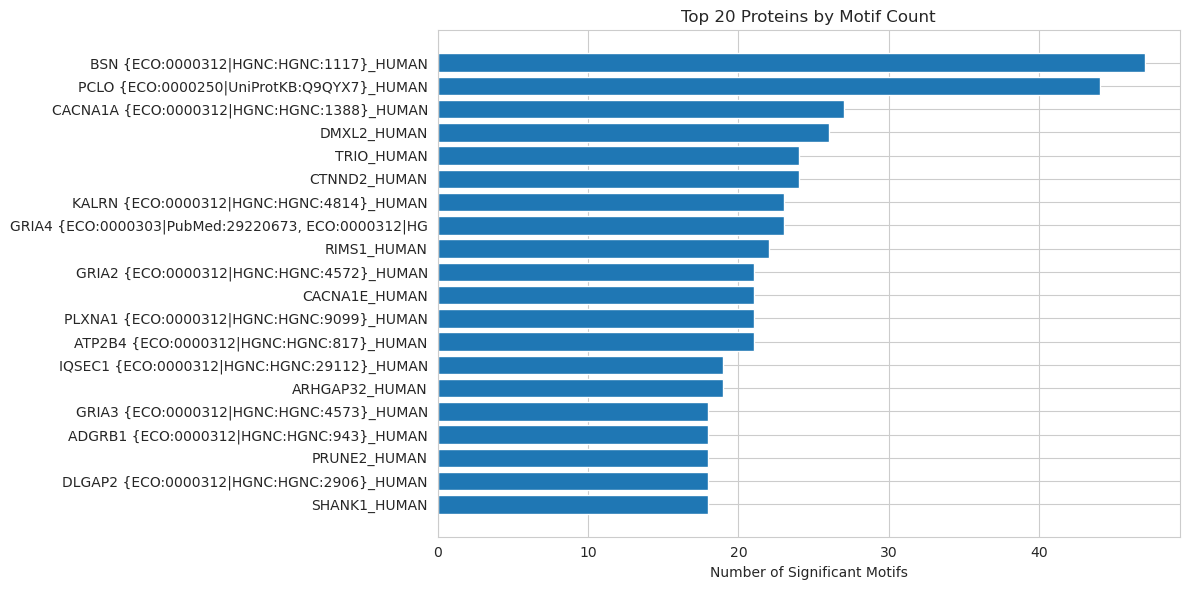


✓ Figure saved to: /home/aditya/synapse_motif_analysis/outputs/excitatory/analysis_results/top_proteins_by_motif_count.png


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))


top_20 = df_protein_summary.head(20)
plt.barh(range(len(top_20)), top_20['NUMBER_OF_SIGNIFICANT_MOTIFS'])
plt.yticks(range(len(top_20)), top_20['GENE_NAME'].str[:50])  
plt.xlabel('Number of Significant Motifs')
plt.title('Top 20 Proteins by Motif Count')
plt.gca().invert_yaxis()
plt.tight_layout()

fig_path = OUTPUT_DIR / "top_proteins_by_motif_count.png"
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Figure saved to: {fig_path}")

## 13. Visualization: Motif Distribution Across Windows

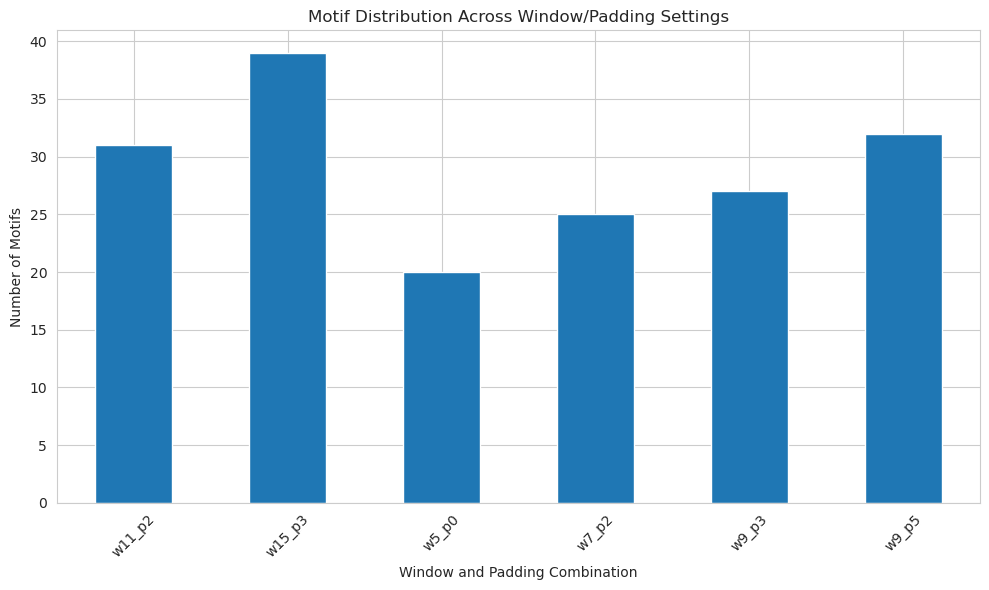


✓ Figure saved to: /home/aditya/synapse_motif_analysis/outputs/excitatory/analysis_results/motif_distribution_by_window.png


In [21]:

window_counts = df_motif_summary['WINDOW_PADDING'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
window_counts.plot(kind='bar')
plt.xlabel('Window and Padding Combination')
plt.ylabel('Number of Motifs')
plt.title('Motif Distribution Across Window/Padding Settings')
plt.xticks(rotation=45)
plt.tight_layout()


fig_path_2 = OUTPUT_DIR / "motif_distribution_by_window.png"
plt.savefig(fig_path_2, dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Figure saved to: {fig_path_2}")

## 14. Export Top Motifs for Each Window

In [22]:

top_motifs_per_window = df_motif_summary.groupby('WINDOW_PADDING').apply(
    lambda x: x.nlargest(10, 'NUMBER_OF_PROTEINS_CONTAINING_THIS_MOTIF')
).reset_index(drop=True)

output_file_3 = OUTPUT_DIR / "top_motifs_per_window.csv"
top_motifs_per_window.to_csv(output_file_3, index=False)

print(f"✓ Top motifs per window saved to: {output_file_3}")
print(f"\nPreview:")
top_motifs_per_window[['WINDOW_PADDING', 'RANK', 'CONSENSUS', 'NUMBER_OF_PROTEINS_CONTAINING_THIS_MOTIF']].head(20)

✓ Top motifs per window saved to: /home/aditya/synapse_motif_analysis/outputs/excitatory/analysis_results/top_motifs_per_window.csv

Preview:


,WINDOW_PADDING,RANK,CONSENSUS,NUMBER_OF_PROTEINS_CONTAINING_THIS_MOTIF
0,w11_p2,16,RXRXXSXXX,84
1,w11_p2,6,SXXDA,68
2,w11_p2,8,XGKK,55
3,w11_p2,17,HXKXXSX,28
4,w11_p2,3,LVGGLGLA,3
5,w11_p2,9,WFRGLNRI,3
6,w11_p2,10,LXDFP,3
7,w11_p2,15,NVAGVFYILV,3
8,w11_p2,4,MVIGILVFN,2
9,w11_p2,7,TVIILVLY,2


In [23]:

try:
    from openpyxl import load_workbook
    from openpyxl.utils import get_column_letter
    from openpyxl.styles import Alignment
    

    excel_file_1 = OUTPUT_DIR / "motif_summary_with_proteins.xlsx"
    

    with pd.ExcelWriter(excel_file_1, engine='openpyxl') as writer:
        df_motif_summary.to_excel(writer, index=False, sheet_name='Motif Summary')
    

    wb = load_workbook(excel_file_1)
    ws = wb.active
    

    s_nos_col_idx = None
    for idx, cell in enumerate(ws[1], 1):
        if cell.value == 'S_NOS_IN_ORIGINAL_FILE':
            s_nos_col_idx = idx
            break
    
    for column in ws.columns:
        max_length = 0
        column_letter = get_column_letter(column[0].column)
        
        for cell in column:
            try:

                if s_nos_col_idx and cell.column == s_nos_col_idx and cell.row > 1:
                    cell.number_format = '@'  
                    cell.alignment = Alignment(horizontal='left')
                
                if len(str(cell.value)) > max_length:
                    max_length = len(str(cell.value))
            except:
                pass
        
        adjusted_width = min(max_length + 2, 100) 
        ws.column_dimensions[column_letter].width = adjusted_width
    
    wb.save(excel_file_1)

    excel_file_2 = OUTPUT_DIR / "protein_summary_with_motif_counts.xlsx"
    
    with pd.ExcelWriter(excel_file_2, engine='openpyxl') as writer:
        df_protein_summary.to_excel(writer, index=False, sheet_name='Protein Summary')

    wb = load_workbook(excel_file_2)
    ws = wb.active
    for column in ws.columns:
        max_length = 0
        column_letter = get_column_letter(column[0].column)
        for cell in column:
            try:
                if len(str(cell.value)) > max_length:
                    max_length = len(str(cell.value))
            except:
                pass
        adjusted_width = min(max_length + 2, 100)
        ws.column_dimensions[column_letter].width = adjusted_width
    wb.save(excel_file_2)
    
    print(f"✓ Excel files created with auto-adjusted columns:")
    print(f"  - {excel_file_1}")
    print(f"  - {excel_file_2}")
    print(f"\n✓ S_NOS_IN_ORIGINAL_FILE formatted as text (integers separated by commas)")
    print(f"✓ All motifs (including 0-match motifs) are included in Excel files")
    print(f"✓ No #### symbols - columns are pre-sized and properly formatted!")
    
except ImportError:
    print("⚠️ openpyxl not installed. Install with: pip install openpyxl")
    print("   For now, you can manually widen columns in Excel by double-clicking column borders.")
except Exception as e:
    print(f"⚠️ Error creating Excel files: {e}")
    print("   CSV files are still available. In Excel, double-click column borders to auto-fit.")

✓ Excel files created with auto-adjusted columns:
  - /home/aditya/synapse_motif_analysis/outputs/excitatory/analysis_results/motif_summary_with_proteins.xlsx
  - /home/aditya/synapse_motif_analysis/outputs/excitatory/analysis_results/protein_summary_with_motif_counts.xlsx

✓ S_NOS_IN_ORIGINAL_FILE formatted as text (integers separated by commas)
✓ All motifs (including 0-match motifs) are included in Excel files
✓ No #### symbols - columns are pre-sized and properly formatted!
